In [3]:
# one time install librosa in Codio env
!pip install librosa
!pip install pretty_midi
!pip install tensorflow

# !pip install magenta
# !pip install --upgrade --no-cache-dir numpy
# !pip install --upgrade --no-cache-dir pip setuptools wheel
# !pip install --upgrade --no-cache-dir numpy scipy pandas



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=5e49e9199e9f02fc104977c51bc0be41e81de4a06b536de43e976ac6dbdacd05
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [1]:
pip list | grep numpy

numpy                              1.26.4


In [53]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pretty_midi
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from tensorflow.keras import layers, models
#from magenta import magenta_convert

## Unzip Audio Files for Train & Test

In [6]:
training_audio_zip_file = "sample_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.mp3.zip"

with zipfile.ZipFile(training_audio_zip_file, "r") as zip_ref:
    zip_ref.extractall("sample_data/processed_data")

testing_audio_zip_file = "sample_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.mp3.zip"

with zipfile.ZipFile(testing_audio_zip_file, "r") as zip_ref:
    zip_ref.extractall("sample_data/processed_data")

In [7]:

# Define old and new file names
old_training_file_name = "sample_data/processed_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.mp3"
new_training_file_name = "sample_data/processed_data/MIDI-Unprocessed_unzipped-train.mp3"

# Rename the file
os.rename(old_training_file_name, new_training_file_name)

print(f"File renamed from {old_training_file_name} to {new_training_file_name}")

old_testing_file_name = "sample_data/processed_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.mp3"
new_testing_file_name = "sample_data/processed_data/MIDI-Unprocessed_unzipped-test.mp3"

# Rename the file
os.rename(old_testing_file_name, new_testing_file_name)

print(f"File renamed from {old_testing_file_name} to {new_testing_file_name}")



File renamed from sample_data/processed_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.mp3 to sample_data/processed_data/MIDI-Unprocessed_unzipped-train.mp3
File renamed from sample_data/processed_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2.mp3 to sample_data/processed_data/MIDI-Unprocessed_unzipped-test.mp3


### Digitize Audio Signal & Load in Variables
Digital audio is a discrete representation of continuous sound waves.
Sampling rate refers to the number of times per second that a sound wave is measured (or sampled) to create the digital representation. It's measured in Hertz (Hz).
A higher sampling rate generally captures more detail of the audio, leading to better quality.
Why 22050 Hz?

Common Standard: 22050 Hz is a widely used standard sampling rate in audio processing. It's considered sufficient for capturing the frequencies audible to most humans.

Nyquist-Shannon Sampling Theorem states that to accurately reconstruct a signal, the sampling rate must be at least twice the highest frequency present in the signal. Since the human hearing range is roughly up to 20,000 Hz, 22050 Hz provides enough samples to capture those frequencies.

Computational Efficiency: Using a lower sampling rate (like 22050 Hz compared to 44100 Hz) can reduce the amount of data and processing power needed, making tasks like feature extraction and model training more efficient.

In [8]:
# Load MP3 file
train_audio_path = "sample_data/processed_data/MIDI-Unprocessed_unzipped-train.mp3"  # Ensure this points to the correct MP3 file

# By setting sr=22050 in librosa.load, you are instructing the library to load the audio file and resample it to a sampling rate of 22050 Hz if it's originally at a different rate. This ensures that the audio data is processed and analyzed consistently at this standard rate. It also helps in aligning the audio with the MIDI data, which is often represented at a lower time resolution.
y, sr = librosa.load(train_audio_path, sr=22050)  # Load with librosa. y and sr are the audio data and sampling rate.

# Compute Mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)


#### Outputs
y represents the audio time series data in digital format.
sr is the sampling rate of the audio.

Save the spectrogram as an image or a matrix (NumPy array) to feed into the CNN.


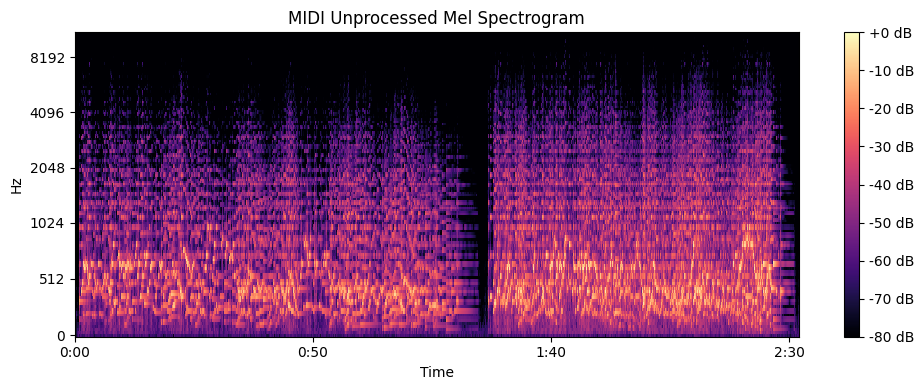

In [9]:
# Display Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('MIDI Unprocessed Mel Spectrogram')
plt.tight_layout()
plt.show()

### The Mel spectrogram plot
It provides a visual representation of the frequency content of your MP3 file over time. Here's what it tells us:

1. X-axis (Time)
Represents time in seconds.
Shows how the audio's frequency components change over time.
2. Y-axis (Frequency - Mel Scale)
Represents frequency, but instead of linear Hz, it's in the Mel scale, which aligns with human perception.
Lower values = lower-pitched sounds (bass, deep voice).
Higher values = higher-pitched sounds (treble, sharp sounds).
3. Color Intensity (dB - Decibels)
Shows the amplitude (loudness) of each frequency component.
Brighter (yellow/white) = louder sounds at that frequency.
Darker (blue/purple) = softer sounds.

### Align Audio and MIDI
To train the CNN, you need aligned audio and MIDI representations:
Spectrogram (input) and piano roll (output) must correspond in time.
Use libraries like pretty_midi or custom alignment logic to ensure this.


In [10]:
# Load MIDI file
midi_path = "sample_data/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1.midi"
midi_data = pretty_midi.PrettyMIDI(midi_path)

# Convert to piano roll
piano_roll = midi_data.get_piano_roll(fs=100)  # fs = frame rate


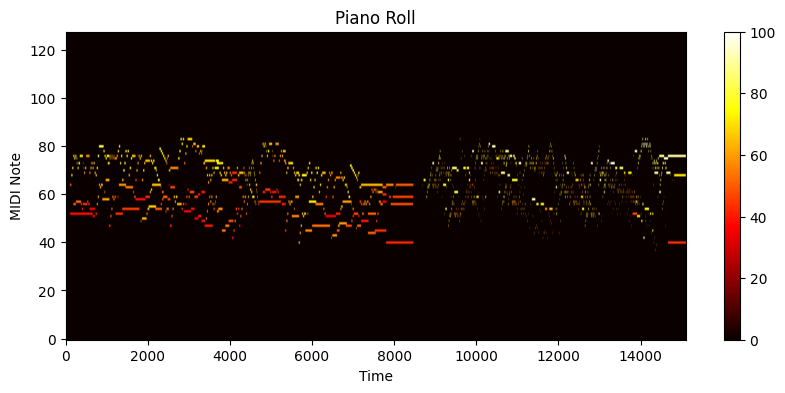

In [11]:
# Display piano roll
plt.figure(figsize=(10, 4))
plt.imshow(piano_roll, aspect='auto', cmap='hot', origin='lower')
plt.title('Piano Roll')
plt.ylabel('MIDI Note')
plt.xlabel('Time')
plt.colorbar()
plt.show()

### The Piano Roll Plot
The piano roll plot provides a visual representation of how MIDI notes are played over time. Here's what it tells us:

1. X-axis (Time)
Represents time in seconds or frames (depending on fs=100).
Shows when notes start and how long they last.
2. Y-axis (MIDI Note Numbers)
Represents pitches of the notes played.
Higher values = higher-pitched notes (treble).
Lower values = lower-pitched notes (bass).
Middle C (C4) = MIDI note 60.
3. Color Intensity (Velocity)
Indicates how strongly or softly the notes are played.
Brighter (yellow/white) = louder notes.
Darker (red/black) = softer notes.


## Audio Data to MIDI Conversion Technique
### Convert mp3 to MIDI
#### Extract Fundamental Frequencies Using Librosa
It is possible to convert mp3 file to MIDI file. We can extract fundamental frequencies and convert them into MIDI notes using librosa library in Python. It is good for single-instrument recordings.

Following code outputs MIDI data in python.

In [12]:
# Load MP3 file
#train_audio_path = "sample_data/processed_data/MIDI-Unprocessed_unzipped-train.mp3"
y, sr = librosa.load(train_audio_path, sr=22050) # y and sr are the audio data and sampling rate.


# Estimate pitch (frequencies)
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

# Convert to MIDI
midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)  # 0 = Acoustic Grand Piano

for t in range(pitches.shape[1]):
    index = np.argmax(magnitudes[:, t])  # Get the most prominent frequency
    pitch = pitches[index, t]
    if pitch > 0:
        note = pretty_midi.Note(
            velocity=100,  # Volume of the note
            pitch=int(librosa.hz_to_midi(pitch)),  # Convert Hz to MIDI note number
            start=t * (1.0 / sr),  # Convert time index to seconds
            end=(t + 1) * (1.0 / sr),
        )
        instrument.notes.append(note)

midi.instruments.append(instrument)

# Save MIDI file
midi.write("sample_data/processed_data/mp3_to_midi.mid")
print("MIDI file saved as mp3_to_midi.mid")

MIDI file saved as mp3_to_midi.mid


### Piano Roll Generation
Following code outputs Piano Roll.
A piano roll is a visual representation of MIDI data where:

The x-axis represents time.
The y-axis represents MIDI note numbers (pitch).
The intensity of the color or a cell value represents the velocity (loudness) of the note.
fs=100: This is a parameter passed to get_piano_roll. It stands for frames per second and determines the time resolution of the piano roll. In this case, fs=100 means that the piano roll will have 100 time frames per second of audio.

In [13]:
# Convert to piano roll
piano_roll_generated_midi = midi.get_piano_roll(fs=100)  # fs = frame rate


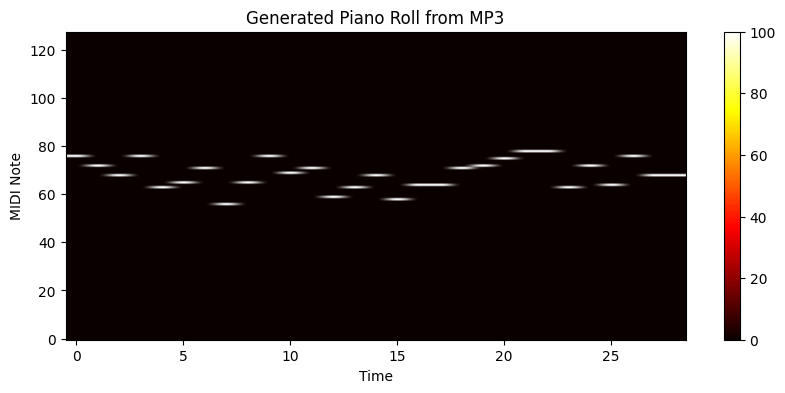

In [14]:
# Display piano roll
plt.figure(figsize=(10, 4))
plt.imshow(piano_roll_generated_midi, aspect='auto', cmap='hot', origin='lower')
plt.title('Generated Piano Roll from MP3')
plt.ylabel('MIDI Note')
plt.xlabel('Time')
plt.colorbar()
plt.show()

### Deep Learning based MIDI Conversion

In [ ]:
# to be explored later as magenta may need specific Python version (Python 3.7 - 3.9)
#magenta_convert audio_path magenta_midi_output.mid

### Normalize Data
Normalize Mel Spectogram and piano roll data and plot them.

In [15]:
# Normalize spectrogram
log_spectrogram = (log_spectrogram - np.mean(log_spectrogram)) / np.std(log_spectrogram)

# Normalize piano roll (binary 0 or 1)
piano_roll = piano_roll > 0

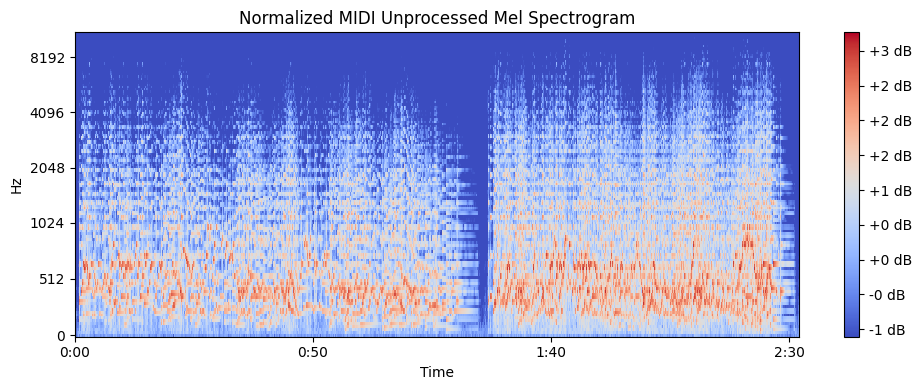

In [16]:
# Display Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized MIDI Unprocessed Mel Spectrogram')
plt.tight_layout()
plt.show()

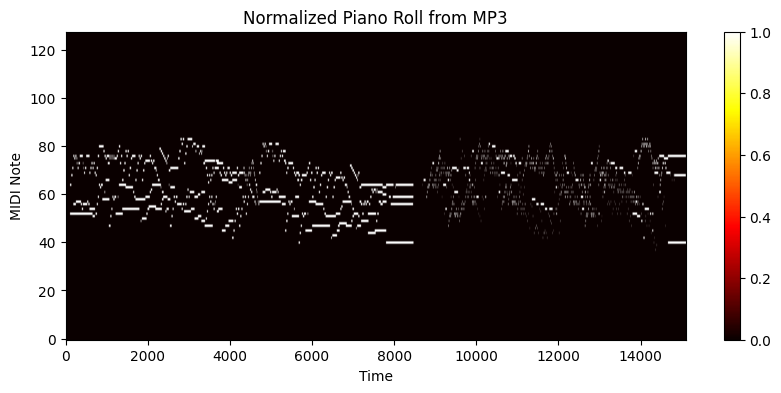

In [17]:
# Display piano roll
plt.figure(figsize=(10, 4))
plt.imshow(piano_roll, aspect='auto', cmap='hot', origin='lower')
plt.title('Normalized Piano Roll from MP3')
plt.ylabel('MIDI Note')
plt.xlabel('Time')
plt.colorbar()
plt.show()

## Data Preparation for Model Training
### Generate Input-Output Pairs Using Digitized Audio as Train Set and Piano Roll as Target
### Split data into smaller time windows (e.g., 1-second chunks) for training.


In [20]:
# Example: Window size and step
window_size = 100  # 100 Timeframes/sec
step_size = 50

# Slice spectrogram and piano roll
X, Y = [], []
for i in range(0, log_spectrogram.shape[1] - window_size, step_size):
    X.append(log_spectrogram[:, i:i+window_size])
    Y.append(piano_roll[:, i:i+window_size])

X = np.array(X)  # Shape: (num_samples, n_mels, window_size)
Y = np.array(Y)  # Shape: (num_samples, n_pitches, window_size)

# checking training data
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Print first sample
print("First X sample:\n", X[0])
print("First Y sample:\n", Y[0])

# print(X.head())
# print(Y.head())

X shape: (129, 128, 100)
Y shape: (129, 128, 100)
First X sample:
 [[-0.86062145 -0.6667322  -0.50488114 ...  0.11597759  0.13914001
  -0.12377572]
 [-0.69119406 -0.20433511 -0.01162304 ...  0.41745925  0.3456962
   0.40845096]
 [-0.47876582 -0.2893684  -0.18125822 ... -0.09102443  0.00535591
   0.4798767 ]
 ...
 [-1.108643   -1.108643   -1.108643   ... -1.108643   -1.108643
  -1.108643  ]
 [-1.108643   -1.108643   -1.108643   ... -1.108643   -1.108643
  -1.108643  ]
 [-1.108643   -1.108643   -1.108643   ... -1.108643   -1.108643
  -1.108643  ]]
First Y sample:
 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [19]:
print(len(X))
print(len(Y))
print(type(X))
print(type(Y))

129
129
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Extract Basic Features of Audio
We can extract Mel Spectrogram and MFCCs (Mel-Frequency Cepstral Coefficients), which are widely used for audio classification.
Why use these features?

Mel Spectrogram represents how sound energy is
distributed across frequencies over time.

1. MFCCs: This is useful for distinguishing different sounds (used in speech recognition and music classification). They capture the spectral envelope of the sound and are robust to variations in loudness and recording conditions.

2. Spectral Centroid: This feature represents the "center of mass" of the spectrum, indicating the average frequency weighted by amplitude.

3. Spectral Bandwidth: This measures the width of the spectrum, indicating the range of frequencies present in the sound.

4. Zero-Crossing Rate: This feature counts the number of times the audio waveform crosses zero, providing information about the frequency content and noisiness of the sound.

5. Chroma Features: These represent the distribution of energy across the 12 chromatic pitches (C, C#, D, etc.), providing information about the harmonic content of the music.

6. Note Onsets and Offsets: You can extract the time points where notes start (onsets) and end (offsets) to analyze rhythmic patterns.

### Extract Features from Piano Roll (Y)

1. Note Density: This feature calculates the number of notes played per time frame, indicating the musical texture.

2. Pitch Class Distribution: This represents the distribution of notes across the 12 pitch classes (C, C#, D, etc.), providing information about the key or scale of the music.




In [25]:
# Feature extraction after splitting
audio_features = []
piano_roll_features = []

print("Length of X: ", len(X))

for i in range(len(X)):
    # Features from digitized audio (X)
    mfccs = librosa.feature.mfcc(y=X[i], sr=sr, n_mfcc=13)  # Assuming you have the sampling rate (sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=X[i], sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=X[i], sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=X[i])
    chroma_features = librosa.feature.chroma_stft(y=X[i], sr=sr)
    onsets = librosa.onset.onset_detect(y=X[i], sr=sr) # Assuming you have audio corresponding to the piano roll


    audio_features.append(np.concatenate([mfccs.flatten(), spectral_centroid.flatten(), spectral_bandwidth.flatten(), zero_crossing_rate.flatten(), chroma_features.flatten()]))  # Combine features

    # Features from piano roll (Y)
    note_density = np.sum(Y[i], axis=0)
    pitch_class_distribution = np.sum(Y[i], axis=1) % 12

    # ... extract other piano roll features ...

    piano_roll_features.append(np.concatenate([note_density, pitch_class_distribution])) # Combine features


# Convert to NumPy arrays
audio_features = np.array(audio_features)
piano_roll_features = np.array(piano_roll_features)





Length of X:  129


In [28]:
# check length and type of audio fetaures and piano roll features
print(len(audio_features))
print(len(piano_roll_features))
print(type(audio_features))
print(type(piano_roll_features))

# Print shapes of individual features
print("MFCCs shape:", mfccs.shape)
print("Spectral Centroid shape:", spectral_centroid.shape)
print("Spectral Bandwidth shape:", spectral_bandwidth.shape)
print("Zero-Crossing Rate shape:", zero_crossing_rate.shape)
print("Chroma Features shape:", chroma_features.shape)
print("Audio Features Shape:", audio_features.shape)
print("Piano Roll Features Shape:", piano_roll_features.shape)

# print("MFCCs:", mfccs)
# Print first sample
print("First X sample:\n", audio_features[0])
print("First Y sample:\n", piano_roll_features[0])


129
129
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
MFCCs shape: (128, 13, 1)
Spectral Centroid shape: (128, 1, 1)
Spectral Bandwidth shape: (128, 1, 1)
Zero-Crossing Rate shape: (128, 1, 1)
Chroma Features shape: (128, 12, 1)
Audio Features Shape: (129, 3584)
Piano Roll Features Shape: (129, 228)
First X sample:
 [-30.56099319  51.93589401   3.58941031 ...   0.66416317   0.72405505
   0.84325153]
First Y sample:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


#### Mel Spectogram and MFCC Visualization

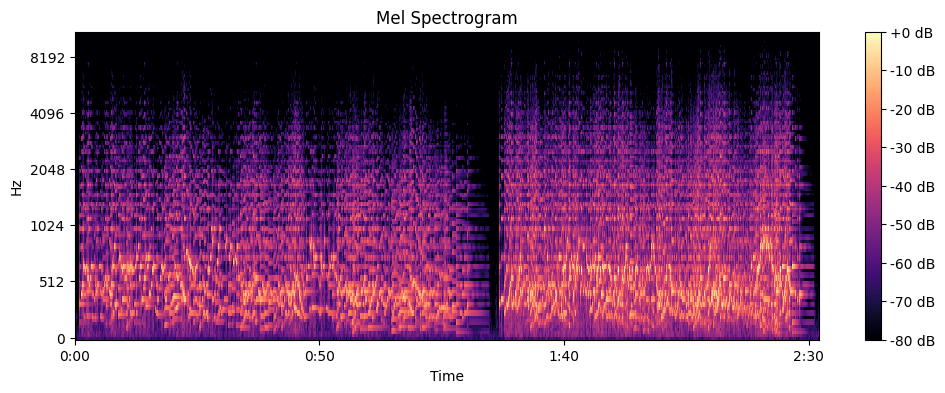

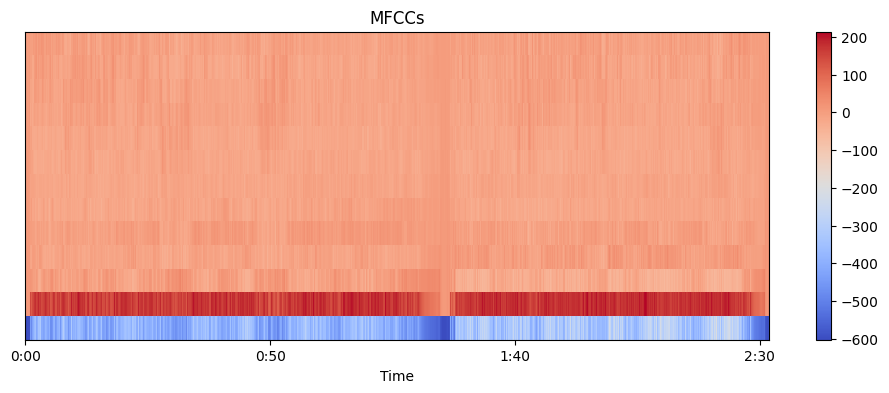

In [ ]:

# Compute Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.show()


### Create Dataframe from Numpy Array for KNN Modeling

I have extracted audio features and have them in a NumPy ndarray (audio_features).
I plan to use KNN for modeling.
Given these points, converting my audio_features to a DataFrame would be beneficial. It will make my code more compatible with scikit-learn's KNN implementation and provide a more organized structure for data.

For KNN modeling, using a Pandas DataFrame is generally recommended, especially if you're using scikit-learn for implementation. Here's why:

1. Scikit-learn compatibility: Scikit-learn's KNeighborsClassifier and KNeighborsRegressor are designed to work seamlessly with DataFrames.
2. Feature organization: DataFrames allow you to easily label your features with meaningful column names, which improves code readability and helps in understanding the model's behavior.
3. Data handling: DataFrames provide convenient methods for handling missing values, data cleaning, and other preprocessing steps that might be necessary before applying KNN.
4. Categorical features: If you have any categorical features, DataFrames offer better support for encoding and handling them compared to NumPy arrays.

In [35]:
# Assuming audio_features has shape (129, 3584)
audio_features_df = pd.DataFrame(audio_features)

# Optionally, add column names
feature_names = [f"feature_{i}" for i in range(3584)]  # Create generic names
audio_features_df.columns = feature_names

print(audio_features_df.head())  # Display the first few rows of the DataFrame



   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -30.560993  51.935894   3.589410  27.074253   4.753155  12.260932   
1 -42.496670  52.031128   5.953609  22.764185   0.858427  13.174939   
2 -57.017395  54.483482  14.378319  36.177368  -0.197684  -2.896238   
3 -54.818832  52.533215   1.774866  35.016438   1.210558  13.652739   
4 -65.514542  52.297665  18.010845  23.250004  -3.975992  17.471584   

   feature_6  feature_7  feature_8  feature_9  ...  feature_3574  \
0   8.350958  16.661098   0.256351   8.578003  ...      1.000000   
1   3.252326  13.301159  -1.931536   2.681314  ...      1.000000   
2  -4.613110  12.413373   1.784850   6.147833  ...      1.000000   
3  -1.091703  10.898511  11.779249  15.334689  ...      0.987276   
4   3.717713  16.213093  23.942772  23.895302  ...      0.990668   

   feature_3575  feature_3576  feature_3577  feature_3578  feature_3579  \
0      0.975853      0.898814      0.909553      0.879123      0.825036   
1      0.93662

#### Discarding below code now as I have audio features dataframe and Y to be used directly


In [ ]:
# Example dataset (Replace with real data)
# X = []  # Feature vectors (MFCCs)
# Y = []  # Labels (Note names)

# note_files = {
#     "C": "C_note.wav",
#     "D": "D_note.wav",
#     "E": "E_note.wav"
# }

# for note, file in note_files.items():
#     y, sr = librosa.load(audio_path, sr=22050)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#     mfcc_mean = np.mean(mfcc, axis=1)  # Take mean across time
#     X.append(mfcc_mean)
#     Y.append(note)

# X = np.array(X)
# Y = np.array(Y)

## Split Train Test Dataset

In [36]:
# Split into training/testing
X_train, X_test, Y_train, Y_test = train_test_split(audio_features_df, Y, test_size=0.2, random_state=42)

In [38]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (103, 3584)
Y_train shape: (103, 128, 100)
X_test shape: (26, 3584)
Y_test shape: (26, 128, 100)


### Understanding the Shapes:

X_train and X_test: These have shapes (103, 3584) and (26, 3584) respectively, which is expected. They represent audio features, with 103 and 26 samples in the training and testing sets, and each sample having 3584 features.

Y_train and Y_test: These have shapes (103, 128, 100) and (26, 128, 100). This indicates that target variable (piano roll data) has three dimensions:
103/26: Number of samples in training/testing sets.
128: Number of MIDI notes (or pitch values) represented in the piano roll.
100: Number of time frames in each window of the piano roll.

### Multi-label or Multi-output:
The shape of Y suggests that I am dealing with a multi-label or multi-output prediction problem. This means that for each audio segment (X), I want to predict a sequence of values representing the piano roll over time. In other words, I am predicting multiple target values simultaneously.

## KNN Model Training
We can train a simple classifier to output MIDI from mp3 audio data.

Since the original target Y has 3 dimensions and KNN cannot handle more than 2 dimensions we need to reshape data.





In [45]:
# This line gets the dimensions of the original 3D piano roll data.
nsamples_train, nx_train, ny_train = Y_train.shape

# This line reshapes the data into a 2D format. It combines the pitch and time dimensions (nx, ny) into a single feature dimension, resulting in a shape of (num_samples, num_features).
Y_train_2d = Y_train.reshape((nsamples_train, nx_train * ny_train))

# Similar steps are performed for Y_test.
nsamples_test, nx_test, ny_test = Y_test.shape
Y_test_2d = Y_test.reshape((nsamples_test, nx_test * ny_test))

In [46]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train_2d)  # Use reshaped Y_train

# # Test the model
# accuracy = knn.score(X_test, Y_test_2d)  # Use reshaped Y_test
# print(f"Model Accuracy: {accuracy:.2f}")

KNeighborsClassifier(n_neighbors=3)

## Model Evaluation
Use X_test => 20% of training dataset

In [51]:

predicted_labels = knn.predict(X_test)



(26, 12800)
Predicted Labels: [False False False ... False False False]


In [52]:
print(predicted_labels.shape)
print(Y_test_2d.shape)
print(f"Predicted Labels: {predicted_note[0]}")
# print(type(predicted_note))
# print(predicted_note)

(26, 12800)
(26, 12800)
Predicted Labels: [False False False ... False False False]


## Model Perforamance Measurement

### F1-Score:
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of accuracy, especially when dealing with imbalanced datasets.

In [54]:

f1_score_value = f1_score(Y_test_2d, predicted_labels, average='samples')  # 'samples' for multi-label
print(f"F1-Score: {f1_score_value:.2f}")

F1-Score: 0.20


### Jaccard Score (or Jaccard Similarity)
This metric measures the similarity between the predicted and true sets of labels for each sample. It ranges from 0 to 1, with higher values indicating better performance.

In [55]:

jaccard_score_value = jaccard_score(Y_test_2d, predicted_labels, average='samples')  # 'samples' for multi-label
print(f"Jaccard Score: {jaccard_score_value:.2f}")

Jaccard Score: 0.12


#### Since Jaccard Score values closer to 1 is better, this value indicates it is not a good prediction.


In [57]:
# will take a look at it later as the ouput report is big
from sklearn.metrics import classification_report

#report = classification_report(Y_test_2d, predicted_labels, zero_division=1)  # Handle zero division



## Normalize Data for Better Performance

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Normalize audio_features_df (StandardScaler for features with Gaussian distribution)
scaler = StandardScaler()
audio_features_df = pd.DataFrame(scaler.fit_transform(audio_features_df), columns=audio_features_df.columns)

# Normalize piano roll (MinMaxScaler for binary data)
# Y is already binary (True/False), but converting to 0/1 is recommended
Y = Y.astype(int)  # Convert True/False to 1/0
# Reshape Y to 2D for scaling
nsamples, nx, ny = Y.shape
Y_2d = Y.reshape((nsamples, nx * ny))
scaler_y = MinMaxScaler()
Y_2d = scaler_y.fit_transform(Y_2d)
# Reshape Y back to 3D
#Y = Y_2d.reshape((nsamples, nx, ny))

# Now you can proceed with train_test_split:
X_train, X_test, Y_train, Y_test = train_test_split(audio_features_df, Y_2d, test_size=0.2, random_state=42)

In [59]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (103, 3584)
Y_train shape: (103, 12800)
X_test shape: (26, 3584)
Y_test shape: (26, 12800)


In [66]:
knn_for_norm = KNeighborsClassifier(n_neighbors=3)
knn_for_norm.fit(X_train, Y_train)


KNeighborsClassifier(n_neighbors=3)

In [68]:
predicted_labels_for_norm = knn_for_norm.predict(X_test)

In [69]:
print(predicted_labels_for_norm.shape)
print(Y_test.shape)

(26, 12800)
(26, 12800)


In [70]:
jaccard_score_value_for_norm = jaccard_score(Y_test, predicted_labels_for_norm, average='samples')  # 'samples' for multi-label
print(f"Jaccard Score: {jaccard_score_value_for_norm:.2f}")

Jaccard Score: 0.17


#### Model Performance slightly increased after normalization.

## Neural Net for Modeling

In [79]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disables GPU usage
model = models.Sequential([
    layers.Input(shape=(3584,)),  # Add channel dimension
    layers.Reshape((1, 1, 3584)), # The input shape here may be too narrow.
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Since the input has dimensions 1x1, using 'same' padding will prevent the output size from decreasing.
    layers.MaxPooling2D((2, 2), padding='same'), # Change padding to 'same' for MaxPooling2D
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'), # Change padding to 'same' for MaxPooling2D
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(128 * 100, activation='sigmoid'),  # Output piano roll
    # The output is flattened here to match the shape of Y_train
    layers.Reshape((12800,))
])

# Remove the extra Reshape layer from the original code
# model.add(layers.Reshape((128, 100)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [80]:
print(X_train.shape)
print(Y_train.shape)

(103, 3584)
(103, 12800)


In [81]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 0.0000e+00 - loss: 0.6925 - val_accuracy: 0.0000e+00 - val_loss: 0.6867
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.0000e+00 - loss: 0.6779 - val_accuracy: 0.0000e+00 - val_loss: 0.6441
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.0000e+00 - loss: 0.5879 - val_accuracy: 0.0000e+00 - val_loss: 0.5018
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.0178 - loss: 0.3668 - val_accuracy: 0.0000e+00 - val_loss: 0.2766
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.0178 - loss: 0.1497 - val_accuracy: 0.0000e+00 - val_loss: 0.1416
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.0000e+00 - loss: 0.1112 - val_accuracy: 0.0000e+00 - val_loss: 0.1016
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.0000e+00 - loss: 0.1120 - val_accuracy: 0.0000e+00 - val_loss: 0.0888
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.0000e+

In [82]:
predicted_labels_for_cnn = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [83]:
print(predicted_labels_for_cnn.shape)
print(Y_test.shape)

(26, 12800)
(26, 12800)


In [85]:
# Threshold predictions to get binary values
predicted_labels_for_cnn = (predicted_labels_for_cnn > 0.5).astype(int)  # Convert to 0/1

# Now calculate the Jaccard score
jaccard_score_value_for_cnn = jaccard_score(Y_test, predicted_labels_for_cnn, average='samples')  # 'samples' for multi-label
print(f"Jaccard Score: {jaccard_score_value_for_cnn:.2f}")


Jaccard Score: 0.17


## TODO: Testing New Audio Files with KNN

In [ ]:
# Predict a note from a new audio file
test_audio_path = "sample_data/processed_data/MIDI-Unprocessed_unzipped-test.mp3"
test_audio, _ = librosa.load(test_audio_path, sr=22050)
test_mfcc = librosa.feature.mfcc(y=test_audio, sr=sr, n_mfcc=13)
test_mfcc_mean = np.mean(test_mfcc, axis=1).reshape(1, -1)

predicted_note = knn.predict(test_mfcc_mean)
print(f"Predicted Note: {predicted_note[0]}")
print(type(predicted_note))
print(predicted_note)

Predicted Note: D
<class 'numpy.ndarray'>
['D']
